# Bootstrap Homework

In this homework we will use the bootstrap to solve a financial problem: 

We will
1. Review the properties of the t-student probability distribution and how we can use it to model the **fat tails** of stock market index returns.
2. We will work out how  estimate the uncertainty of index returns distributions using the bootstrap method.

3.(Optional) We will extend the example to perform  **robust regression**  between SPX and NDX indexes.

Given the distributional assumptions made and the size of the data samples, there are no readily available good analytic approximation to the standard deviation of parameter estimates. In this case the bootstrap the easiest method to generate those estimates.

Problems 1-4 are due for everyone. Bonus Problems 5 and 6 are optional. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt

In [2]:
seed=57375
rng=np.random.default_rng(seed)

## Problem 1: Data

<div class="alert alert-block alert-info"> Problem 1.1 </div>

Save files `index_returns_train.csv` and `index_returns_test.csv` to your local computer.

Both data sets contain the returns of the S&P 500 and Nasdaq equity indexes on different historical periods.


<div class="alert alert-block alert-info"> Problem 1.2 </div>

Read the data from both files  into a `train_returns` DataFrame and a `test_returns` DataFrame.

In [3]:
train_returns = pd.read_csv('/Users/jordialonsoguardia/Sim_apps/hw#6_Bootstrap(1)/index_returns_train.csv', index_col = 'Date')
test_returns = pd.read_csv('/Users/jordialonsoguardia/Sim_apps/hw#6_Bootstrap(1)/index_returns_test.csv', index_col = 'Date')

In [4]:
display(train_returns)
display(test_returns)

,SPX,NDX
Date,,
2017-12-29,-0.005183,-0.006986
2018-01-02,0.008303,0.017966
2018-01-03,0.006399,0.009900
2018-01-04,0.004029,0.001335
2018-01-05,0.007034,0.010435
...,...,...
2019-12-24,-0.000195,0.000402
2019-12-26,0.005128,0.009058
2019-12-27,0.000034,-0.000835


,SPX,NDX
Date,,
2020-01-02,0.008379,0.015934
2020-01-03,-0.007060,-0.008827
2020-01-06,0.003533,0.006211
2020-01-07,-0.002803,-0.000234
2020-01-08,0.004902,0.007452
...,...,...
2022-02-25,0.022373,0.015349
2022-02-28,-0.002443,0.003429
2022-03-01,-0.015474,-0.016282


<div class="alert alert-block alert-info"> Problem 1.3 </div>

Inpect the `train_returns` dataset:

1. How may  columns do you have? And what are their names
2. How many rows of data do you have, what historical period does it cover?


In [5]:
train_returns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, 2017-12-29 to 2019-12-31
Data columns (total 2 columns):
SPX    504 non-null float64
NDX    504 non-null float64
dtypes: float64(2)
memory usage: 11.8+ KB


*The dataframe train_returns has 2 columns, named "SPX" and "NDX". The data has 504 rows, and it covers historical period from 2017-12-29 to 2019-12-31.*

<div class="alert alert-block alert-info"> Problem 1.4 </div>

Inpect the `test_returns` dataset:

1. How may  columns do you have? And what are their names
2. How many rows of data do you have, what historical period does it cover?


In [6]:
test_returns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547 entries, 2020-01-02 to 2022-03-03
Data columns (total 2 columns):
SPX    547 non-null float64
NDX    547 non-null float64
dtypes: float64(2)
memory usage: 12.8+ KB


*The dataframe train_returns has 2 columns, named "SPX" and "NDX". The data has 547 rows, and it covers historical period from 2020-01-02 to 2022-03-03.*

<div class="alert alert-block alert-info"> Problem 1.5 </div>

Define `numpy` arrays:

1. `SPX` containing the returns of S & P 500  during the training period.
2.  `NDX` containing the returns of Nasdaq on the training period.
3.  `SPX_test` containing the returns of S & P 500 on the test period.
4.  `NDX_test` containing the returns of Nasdaq on the test period.
    
[HINT] you can use the DataFrame function [to_numpy()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html#pandas.DataFrame.to_numpy) tp extract data from a DataFrame.

In [7]:
SPX = np.array(train_returns.SPX)
NDX = np.array(train_returns.NDX)
SPX_test = np.array(test_returns.SPX)
NDX_test = np.array(test_returns.NDX)

## Problem 2: Student-T distribution

Equity index returns exhibit **fat tails**: large deviations from the mean are move likely than what would be predicted by a Gaussian distribution.

One possible ways to model fat tail distributions is using a **Student-T** distribution. 

### Normalized Student-T  Distribution

The (normalized) **student's t** distribution
$$
    X \sim t_n
$$
is the distribution of the ratio of a normaly distributed random variable  and the square root of a Chi-squared distributed independent random variable

$$
    t_n \sim \frac{Z}{S} \ \ \ \ \text{where }\ Z\sim \mathcal{N}(0,1)\ \ \ \text{and }\ S^2 \sim \frac{\chi_n^2}{n}
$$
    
the pdf of the $t_n$ distribution is given by

$$
    p(x;n) = \frac{\Gamma\left(\frac{n+1}{2}\right)}{\sqrt{n\pi}\Gamma\left(\frac{n}{2}\right)}\left(1 + \frac{x^2}{n} \right)^{-\frac{n+1}{2}}\ \ \ \ \text{where }\ -\infty < x < \infty 
$$

Student's $t_n$ distribution appears naturally when performing **hypothesis tests** about the means of Gaussian random variables from finite samples.



The the key properties of  (normalized) Student's $t_n$ distribution are:

1. It is symmetric around its mean.
2. $n$ is called the **degrees of freedom** of the distribution.
3. $t_n$  is well defined for $n>1$
3. As $n$ becomes large Student's $t_n$ distribution approaches a normal distribution $\mathcal{N}(0,1)$.

Text(0, 0.5, 'pdf($t$)')

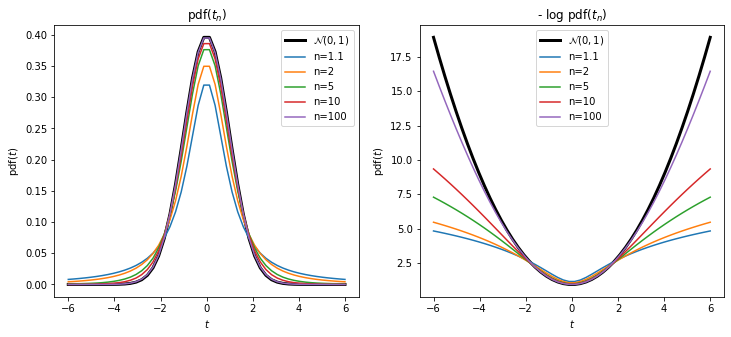

In [8]:
fig=plt.figure(figsize=(12,5))

x=np.linspace(-6,6)

plt.subplot(121)
plt.title(r"pdf($t_n$)")

dist_normal=stats.norm(0,1)
plt.plot(x,dist_normal.pdf(x),color="k",linewidth=3,label=r"$\mathcal{N}(0,1)$")
ns=[1.1,2,5,10,100]
for n in ns:
    dist=stats.t(df=n)
    plt.plot(x,dist.pdf(x),label=f"n={n}")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("pdf($t$)")

plt.subplot(122)
plt.title(r"- $\log$ pdf($t_n$)")

dist_normal=stats.norm(0,1)
plt.plot(x,-dist_normal.logpdf(x),color="k",linewidth=3,label=r"$\mathcal{N}(0,1)$")
ns=[1.1,2,5,10,100]
for n in ns:
    dist=stats.t(df=n)
    plt.plot(x,-dist.logpdf(x),label=f"n={n}")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("pdf($t$)")

### Distribution of Stock Returns

`scipy.stats` defines a [t distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) with three parameters:
1. `df` is the number of degrees of freedom (our $n$ parameter), $1 < n$
2. `loc` the maximum of the distribution (our $\mu$ parameter), $-\infty < \mu, < \infty $ 
3. `scale` the scale of the distribution (our $\sigma$ parameter), $ 0 < \sigma$

so that

$$
    \text{stats.t}(\text{df}=n,\text{loc}=\mu,\text{scale}=\sigma) \sim \mu + \sigma\, t_n
$$

where $t_n$ is the normalized Studen-t $t$ distribution we defined above.

We would like to assume  NDX returns follow a Student's-T distribution with parameters $n,\mu,\sigma$:

$$
    \text{NDX} \sim \text{stats.t}(\text{df}=n,\text{loc}=\mu,\text{scale}=\sigma)
$$

We will define a parameter vector $\theta=(\theta_1,\theta_2,\theta_3)$ as follows:

\begin{align*}
     \theta_1 & = \log ( n -1)    \\
     \theta_2 & = \mu \\
     \theta_3 & = \log \sigma
\end{align*}

so that, given any vector $\theta$ we can reconstruct the  distribution parameters as:

\begin{align*}
    n &= 1 + e^{\theta_1}  &( 1<n) \\
    \mu &= \theta_2  \\
    \sigma &= e^{\theta_2}   &( 0<\sigma) \\
\end{align*}

<div class="alert alert-block alert-info"> Problem 2.1 </div>

Given parameter guess
1. $n_\text{guess}=3$
2. $\mu_\text{guess}=0$
3. $\sigma_\text{guess}=0.001$

Define a `numpy` array containing  the   3-dimentional vector parameter vector $\theta=(\theta_1,\theta_2,\theta_3)$ 

In [9]:
#initial guess
n_guess = 3
mu_guess = 0
sigma_guess = 0.001

#thetas defining
theta_0 = np.log(n_guess-1)
theta_1 = mu_guess
theta_2 = np.log(sigma_guess)
theta = np.array([theta_0,theta_1,theta_2])

#From theta to n, mu and sigma
def n_transform(a): return (1+np.exp(a))
def mu_transform(a): return (a)
def sigma_transform(a): return (np.exp(a))

theta

array([ 0.69314718,  0.        , -6.90775528])

<div class="alert alert-block alert-info"> Problem 2.2 </div>

Define the student's distribution negative log likelihood loss,  defined as:

$$
    L(\theta; X) = -\sum_{i=1}^N \log P_\theta (x_i)
$$

where $P_\theta$ is the t-student's distribution pdf as defined by the 3 parameters $\theta$ 

[HINTS] 
1. Scipy's [student's t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) distribution implements 
a `logpdf(x)` method returning the log probability density of observation $x$. You do not need to implement any complicated formulas.
2. To define the distribution you can use the constructor
    dist=student.t(df=n,loc=mu,scale=sigma)
3.  You must use the formulas defined at the begining of problem 3 to transform from $\theta$ to $n,\mu,\sigma$

In [10]:
def student_loss(theta,X):
    n = 1+ np.exp(theta[0])
    mu = theta[1]
    sigma = np.exp(theta[2])
    
    dist = stats.t(df=n,loc=mu,scale=sigma)
    lp = dist.logpdf(X)
    return (-np.sum(lp))
    pass # write your implementation here

<div class="alert alert-block alert-info"> Problem 2.3 </div>

Evaluate the student's distribution loss using our $\theta_\text{guess}$ parameters and the `NDX` returns in the training period.

In [11]:
student_loss(theta, NDX)

-306.32515010482354

<div class="alert alert-block alert-info"> Problem 2.4 </div>

Use [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to find the
parameters $\theta_\text{ML}$$ that minimze the Student's-T loss.

[HINTS]
1. [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) minimizes 
a function $f(x)$ over aparameter $x$, in our case $x$ is $\theta$.
2. The relevant part of the signature of scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)
is
    fit=scipy.optimize.miminize(loss,theta_guess,args=(<other parameters to loss>))
3. The `fit` object contains a variable `fit.x` with the parameters that minimize $f(x)$.

In [12]:
import scipy.optimize as opt

theta_guess = np.array([0,0,0])
fit= opt.minimize(student_loss,theta_guess,args=(NDX,))
theta_ML = fit.x
theta_ML

array([ 7.67067467e-01,  1.50247758e-03, -4.78805964e+00])

In [13]:
student_loss

<function __main__.student_loss(theta, X)>

**Student_loss is the function. Thats the first parameter. After that goes parameter to minimize, theta_guess and any other parameters we need.**

<div class="alert alert-block alert-info"> Problem 2.5 </div>

compute the Student's T loss with the optimal parameters $\theta_\text{ML}$ and verify that is smaller that the loss with our initial guess $\theta_{\text{guess}}$:

In [14]:
print(student_loss(theta,NDX))
print(student_loss(fit.x,NDX))

-306.32515010482354
-1528.4015360808971


<div class="alert alert-block alert-info"> Problem 2.6 </div>

Transform $\theta_{\text{ML}}$ into $n_{\text{ML}}$, $\mu_{\text{ML}}$, $\sigma_{\text{ML}}$:

In [15]:
n_ML=n_transform(theta_ML[0])
mu_ML = mu_transform(theta_ML[1])
sigma_ML = sigma_transform(theta_ML[2])

<div class="alert alert-block alert-info"> Problem 2.7 </div>

Compare your parameters to the result of [ scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html)
`fit(X)` method

In [16]:
print(n_ML, mu_ML, sigma_ML)
print(stats.t.fit(NDX))

3.153441945995864 0.0015024775752680122 0.008328602211971306
(3.1534181494302853, 0.0015025104197403305, 0.008328579290821342)


<div class="alert alert-block alert-info"> Problem 2.8 </div>

Using the constructor `scipy.stats.t(df,loc,scale)` define a [ scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) distribution with
the maximum likelihood estimate of the parameter $n,\mu,\sigma$:

In [17]:
dist = stats.t(df=n_ML,loc=mu_ML,scale=sigma_ML)
np.sum(dist.logpdf(NDX))

1528.4015360808971

In [18]:
def student_MLE(theta, X):
    n = 1+ np.exp(theta[0])
    mu = theta[1]
    sigma = np.exp(theta[2])
    
    dist = stats.t(df=n,loc=mu,scale=sigma)
    pdf = dist.logpdf(X)
    return (np.sum(pdf))
    pass # write your implementation here

In [19]:
student_MLE(theta_ML, NDX)

1528.4015360808971

<div class="alert alert-block alert-info"> Problem 2.9 </div>

1. Plot a histogram of the historical `NDX` returns

2. Add a plot of Student's-T maximum likelihood distribution pdf.

3. Add a plot of the Gaussian   maximum likelihood estimate pdf.

4. Which distribution fits better, Student's-T or Gaussian?

[HINTS]
1. use the argument `density=True` to [matplotlib.pyplot.hist](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.hist.html)
   so that the histogram is normalized as a pdf.
2. The default number of bins in `hist()` is too small, use a larger number of bins i.e `bins=np.linspace(-0.1,0.1,25)`.
2. You can use the method `fit()` of [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)
   to find the best fitting Gaussian (but you can also compute mean and standard deviation by hand if you prefer)

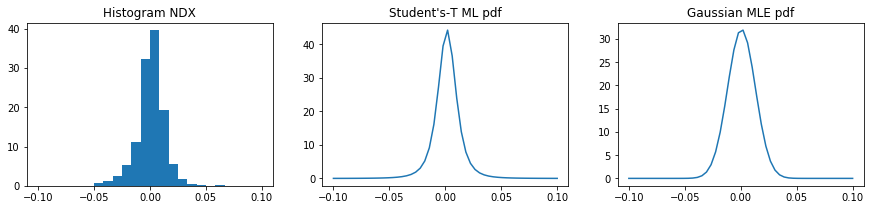

In [20]:
fig = plt.figure(figsize=(15,3))
plt.subplot(131)
plt.title('Histogram NDX')
plt.hist(NDX, bins=np.linspace(-0.1,0.1,25), density = True);
plt.subplot(132)
plt.title("Student's-T ML pdf")
plt.plot(np.linspace(-0.1, 0.1, 50),dist.pdf(np.linspace(-0.1, 0.1, 50)))
plt.subplot(133)
plt.title('Gaussian MLE pdf')
theta_norm = stats.norm.fit(NDX)
dist_normal=stats.norm(theta_norm[0],theta_norm[1])
plt.plot(np.linspace(-0.1, 0.1, 50),dist_normal.pdf(np.linspace(-0.1, 0.1, 50)))

The students T distribution seems to do a better job at fitting the data than the gaussian


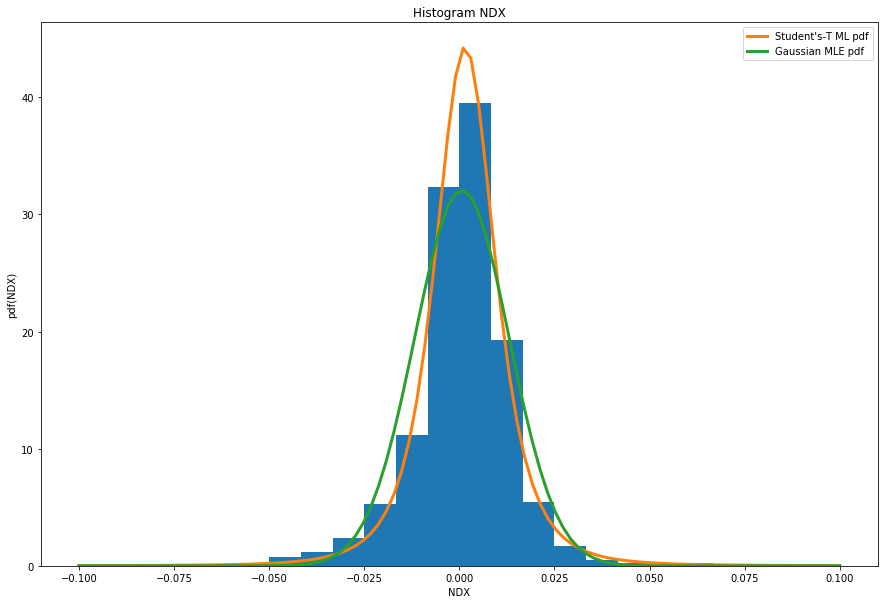

In [21]:
fig = plt.figure(figsize=(15,10))
plt.title('Histogram NDX')
plt.hist(NDX, bins=np.linspace(-0.1,0.1,25), density = True);
plt.plot(np.linspace(-0.1, 0.1,100),dist.pdf(np.linspace(-0.1, 0.1, 100)),linewidth=3,label="Student's-T ML pdf")
theta_norm = stats.norm.fit(NDX)
dist_normal=stats.norm(theta_norm[0],theta_norm[1])
plt.plot(np.linspace(-0.1, 0.1, 100),dist_normal.pdf(np.linspace(-0.1, 0.1, 100)), linewidth=3,label="Gaussian MLE pdf")
plt.legend()
plt.xlabel("NDX")
plt.ylabel("pdf(NDX)")

print('The students T distribution seems to do a better job at fitting the data than the gaussian')

## Problem 3:  Parametric Bootstrap

<div class="alert alert-block alert-info"> Problem 3.1 </div>

Use the maximum likelihood distribution you just defined to draw $N$ random samples ($N$ is the number of samples on the `NDX` dataset)

[HINTS] You can use the method `rvs(size=N)` of the [ scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html)  distribution.

In [22]:
N = len(NDX)
dist = stats.t(df=n_ML,loc=mu_ML,scale=sigma_ML)
samples = dist.rvs(size=N)
samples;

<div class="alert alert-block alert-info"> Problem 3.2 </div>

Plot the discribution of the samples just generated (like you did in problem 1.7) and compare it the the plot o the pdf of the maximum likelihood distribution you used to generate the samples.

In [23]:
samples = np.sort(samples)

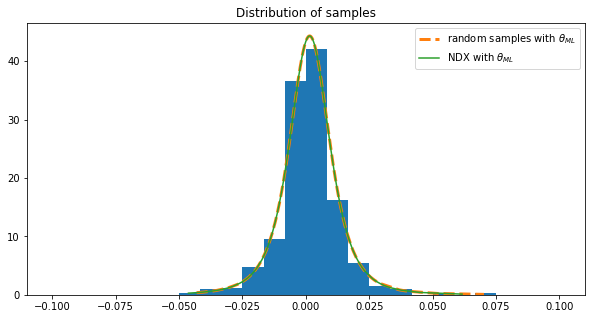

In [24]:
fig = plt.figure(figsize=(10,5))
plt.hist(samples, bins=np.linspace(-0.1,0.1,25),density= True)
plt.plot(samples,dist.pdf(samples), ls = '--', lw = 3, label = r'random samples with $\theta_{ML}$')
plt.plot(np.sort(NDX), dist.pdf(np.sort(NDX)), label = r'NDX with $\theta_{ML}$')
plt.title("Distribution of samples")
plt.legend()

<div class="alert alert-block alert-info"> Problem 3.3 </div>

Implement **parametric bootstrap** with $R=1,000$ repeats:

1. Define an array  `thetas` of size $(R,3)$
2. For $r=1,2,\dots,R$ repeat
    1. Generate a random sample of $N$ points from the maximum likelihood distribution.
    2. Find the maximum likelihood estimate $\theta_r$ of the sampled  data.
3. Return the  array `thetas` of sampled  $\theta_r$ estimates

In [25]:
theta_ML = np.array([n_ML, mu_ML, sigma_ML]); print(theta_ML)
print(theta_guess)

[3.15344195e+00 1.50247758e-03 8.32860221e-03]
[0 0 0]


In [26]:
def parametric_bootstrap(loss_fn, Define_theta_guess, dist_ML, N,R):
    thetas= np.empty((R,len(dist_ML)))
    dist = stats.t(df=dist_ML[0], loc=dist_ML[1], scale=dist_ML[2])
    for r in range(R):
        Zt = dist.rvs(N)
        fit = opt.minimize(loss_fn,theta_guess,args=(Zt,))
        thetas[r]= fit.x        
        
    return thetas
    pass # write your implementation here

In [27]:
thetas = parametric_bootstrap(student_loss, theta_guess, theta_ML, N, 1000)

<div class="alert alert-block alert-info"> Problem 3.4  </div>

Compute the mean and standard deviation of $\theta_1,\theta_2,\theta_3$

In [28]:
for i in range(3):
    print('The mean for theta_', i, 'is', round(thetas[:, i].mean(), 4))
print('-----------')
for i in range(3):
    print('The std for theta_', i, 'is', round(thetas[:, i].std(), 4))   

The mean for theta_ 0 is 0.8119
The mean for theta_ 1 is 0.0015
The mean for theta_ 2 is -4.7851
-----------
The std for theta_ 0 is 0.2316
The std for theta_ 1 is 0.0005
The std for theta_ 2 is 0.0579


<div class="alert alert-block alert-info"> Problem 3.5 </div>

1. Plot the histogram of distributions of parametric bootstrap parameters for  $\theta_1,\theta_2$ and $\theta_3$.
2. Compare it to a plot of the best fitting Gaussian approximation to the distribution of the bootstrap parameters.
3. Clearly highlight in the histogram the maximum likelihood estimated of the parameter that you used to generate the distribution.

In [31]:
thetas_0 = np.sort(thetas[:,0])
thetas_1 = np.sort(thetas[:,1])
thetas_2 = np.sort(thetas[:,2])

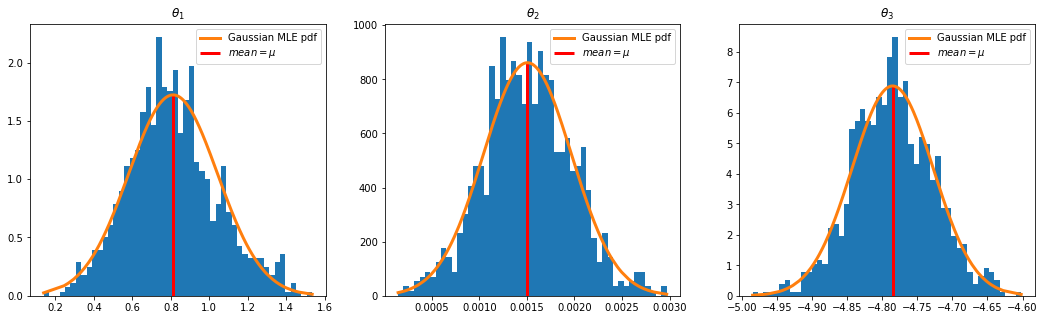

In [32]:
dist = stats.t(df=theta_ML[0], loc=theta_ML[1], scale=theta_ML[2])

def normal(data):
    theta_norm = stats.norm.fit(data)
    dist_normal=stats.norm(theta_norm[0],theta_norm[1])
    return dist_normal

fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.title(r'$\theta_1$')
plt.hist(thetas_0, bins=50, density = True);
plt.plot(thetas_0,normal(thetas_0).pdf(thetas_0), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(thetas_0.mean(), 0,normal(thetas_0).pdf(thetas_0.mean()), color = 'r', lw= 3, label =r'$mean = \mu$')
plt.legend()


plt.subplot(1,3,2)
plt.title(r'$\theta_2$')
plt.hist(thetas_1, bins=50, density = True);
plt.plot(thetas_1,normal(thetas_1).pdf(thetas_1), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(thetas_1.mean(), 0,normal(thetas_1).pdf(thetas_1.mean()), color = 'r', lw= 3, label =r'$mean = \mu$')
plt.legend()

plt.subplot(1,3,3)
plt.title(r'$\theta_3$')
plt.hist(thetas_2, bins=50, density = True);
plt.plot(thetas_2,normal(thetas_2).pdf(thetas_2), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(thetas_2.mean(), 0,normal(thetas_2).pdf(thetas_2.mean()), color = 'r', lw= 3, label =r'$mean = \mu$')
plt.legend()

#plt.plot(thetas_0,dist.pdf(thetas_0), ls = '--', lw = 3, label = r'Distribution of $\theta_{1}$')
#plt.plot(np.sort(NDX), dist.pdf(np.sort(NDX)), label = r'NDX with $\theta_{ML}$')
#plt.title("Distribution of samples")
#plt.legend()

<div class="alert alert-block alert-info"> Problem 3.6 </div>

Generate three arrays of size $R$  `ns_p`, `mus_p` and `sigmas_p` with the parameters $n,\mu,\sigma$ of the parametric bootstrap samples:

[HINTS] Use the formulas from Problem 1 to transform from $\theta_1,\theta_2,\theta_3$ to $n,\mu,\sigma$.

In [33]:
ns_p = n_transform(thetas_0)
mus_p = mu_transform(thetas_1)
sigmas_p = sigma_transform(thetas_2)

<div class="alert alert-block alert-info"> Problem 3.7 </div>

Compute the mean and stardard deviation of the parametric bootstrap samples of $n$, $\mu$ and $\sigma$:

In [34]:
print(r'The mean for bootstrap n is', round(ns_p.mean(), 4))
print(r'The std for bootstrap n is', round(ns_p.std(), 4))
print('---------')
print(r'The mean for bootstrap mu is', round(mus_p.mean(), 4))
print(r'The std for bootstrap mu is', round(mus_p.std(), 4))
print('---------')
print(r'The mean for bootstrap sigma is', round(sigmas_p.mean(), 4))
print(r'The std for bootstrap sigma is', round(sigmas_p.std(), 4))

The mean for bootstrap n is 3.3149
The std for bootstrap n is 0.5611
---------
The mean for bootstrap mu is 0.0015
The std for bootstrap mu is 0.0005
---------
The mean for bootstrap sigma is 0.0084
The std for bootstrap sigma is 0.0005


<div class="alert alert-block alert-info"> Problem 3.8 </div>

1. Plot a histogram of the  distributions of the parametric bootstrap samples of $n$, $\mu$ and $\sigma$
2. Superimpose the best Gaussian fit to the bootstrap distribution of each parameter.
3. Clearly highlight in the histogram the maximum likelihood estimated of the parameter that you used to generate the distribution.

In [35]:
mus_p.max()
y_mean = normal(mus_p).pdf(mus_p.mean())
y_mean

861.2446417577072

In [36]:
mu_ML

0.0015024775752680122

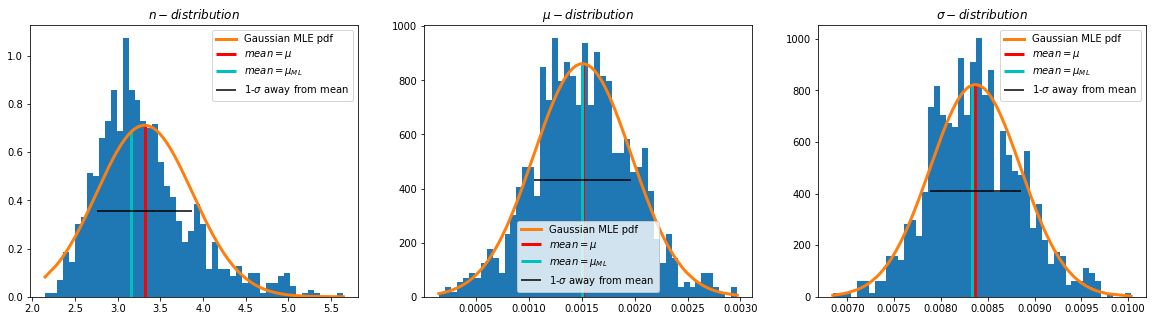

In [37]:
def normal(data):
    theta_norm = stats.norm.fit(data)
    dist_normal=stats.norm(theta_norm[0],theta_norm[1])
    return dist_normal

fig = plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
ns_mean = normal(ns_p).pdf(ns_p.mean())
plt.title(r'$n-distribution$')
plt.hist(ns_p, bins=50, density = True);
plt.plot(ns_p,normal(ns_p).pdf(ns_p), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(ns_p.mean(), 0,normal(ns_p).pdf(ns_p.mean()), color = 'r', lw= 3, label =r'$mean = \mu$')
plt.vlines(n_ML, 0,normal(ns_p).pdf(n_ML), color = 'c', lw= 3, label =r'$mean = \mu_{ML}$')
plt.hlines(y = ns_mean/2 , xmin=(ns_p.mean()-ns_p.std()), xmax=(ns_p.mean()+ns_p.std()), color = 'k', label = r'1-$\sigma$ away from mean')
plt.legend()


plt.subplot(1,3,2)
y_mean = normal(mus_p).pdf(mus_p.mean())
plt.title(r'$\mu -distribution$')
plt.hist(mus_p, bins=50, density = True);
plt.plot(mus_p,normal(mus_p).pdf(mus_p), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(mus_p.mean(), 0,normal(mus_p).pdf(mus_p.mean()), color = 'r', lw= 3, label =r'$mean = \mu$')
plt.vlines(mu_ML, 0,normal(mus_p).pdf(mu_ML), color = 'c', lw= 3, label =r'$mean = \mu_{ML}$')
plt.hlines(y = y_mean/2 , xmin=(mus_p.mean()-mus_p.std()), xmax=(mus_p.mean()+mus_p.std()), color = 'k', label = r'1-$\sigma$ away from mean')
plt.legend()

#hlines(y, xmin, xmax, colors='k', linestyles='solid', label='', *, data=None, **kwargs)[source]¶

plt.subplot(1,3,3)
sigma_mean = normal(sigmas_p).pdf(sigmas_p.mean())
plt.title(r'$\sigma -distribution$')
plt.hist(sigmas_p, bins=50, density = True);
plt.plot(sigmas_p,normal(sigmas_p).pdf(sigmas_p), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(sigmas_p.mean(), 0,normal(sigmas_p).pdf(sigmas_p.mean()), color = 'r', lw= 3, label =r'$mean = \mu$')
plt.vlines(sigma_ML, 0,normal(sigmas_p).pdf(sigma_ML), color = 'c', lw= 3, label =r'$mean = \mu_{ML}$')
plt.hlines(y = sigma_mean/2 , xmin=(sigmas_p.mean()-sigmas_p.std()), xmax=(sigmas_p.mean()+sigmas_p.std()), color = 'k', label = r'1-$\sigma$ away from mean')
plt.legend(loc = 1)


## Problem 4: Non-Parametric Bootstrap

<div class="alert alert-block alert-info"> Problem 4.1 </div>

Generate a sample of $N$ observation by sampling with replacement from the `NDX`  returns of the training period.

[HINTS] Use [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) function of the random number generator.

In [38]:
nonp_sample = np.random.choice(NDX, size= N);

<div class="alert alert-block alert-info"> Problem 4.2 </div>

Make a plot comparing the histogram of non-parametric bootstrap samples to the pdf of the maximum likelihood distribution.

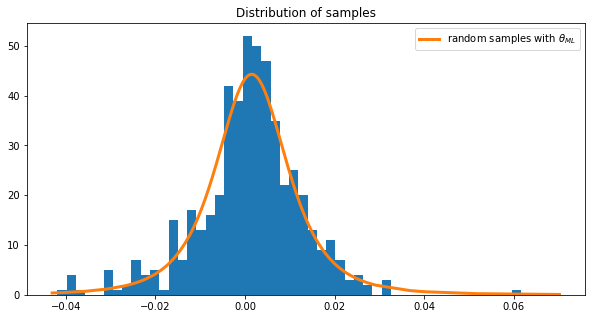

In [39]:
fig = plt.figure(figsize=(10,5))
plt.hist(nonp_sample, bins =50)
plt.plot(samples,dist.pdf(samples), lw = 3, label = r'random samples with $\theta_{ML}$')
plt.title("Distribution of samples")
plt.legend()

<div class="alert alert-block alert-info"> Problem 4.3 </div>

Implement the **non-parametric bootstrap** with $R=1,000$ repeats:

1. Define an array  `thetas` of size $(R,3)$
2. For $r=1,2,\dots,R$ repeat
    1. Chose  with replacement   $N$  random samples  from the `NDX` training returns .
    2. Find the maximum likelihood estimate $\theta_r$ of the sampled  data.
3. Return the  array `thetas` of sampled  $\theta_r$ estimates

In [40]:
def non_parametric_bootstrap(loss,theta_guess,X,R):
    nonp_fit = opt.minimize(loss, theta_guess, args= (X,))
    theta_ML = nonp_fit.x
    thetas= np.empty((R, len(theta_ML)))
    for r in range(R):
        Zt = np.random.choice(X, size = len(X))
        fit = opt.minimize(loss, theta_guess, args=(Zt,))
        thetas[r] = fit.x
    return thetas
    pass # write your implementation here

In [41]:
non_param_samples = non_parametric_bootstrap(student_loss, theta_guess, NDX, 1000)

In [42]:
np_theta0 = np.sort(non_param_samples[:,0])
np_theta1 = np.sort(non_param_samples[:,1])
np_theta2 = np.sort(non_param_samples[:,2])

<div class="alert alert-block alert-info"> Problem 4.4 </div>

Compare the mean and standard deviation of the parametric and non-parametric bootstrap distribution of samples

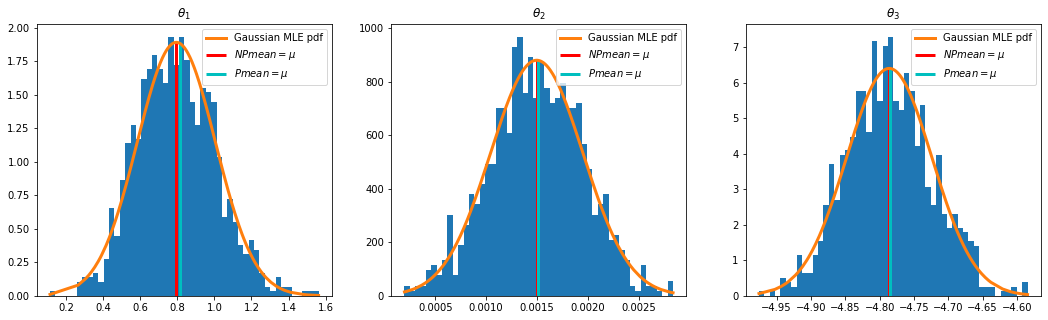

In [43]:
def normal(data):
    theta_norm = stats.norm.fit(data)
    dist_normal=stats.norm(theta_norm[0],theta_norm[1])
    return dist_normal

fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.title(r'$\theta_1$')
plt.hist(np_theta0, bins=50, density = True);
plt.plot(np_theta0,normal(np_theta0).pdf(np_theta0), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(np_theta0.mean(), 0,normal(np_theta0).pdf(np_theta0.mean()), color = 'r', lw= 3, label =r'$NP mean = \mu$')
plt.vlines(thetas_0.mean(), 0,normal(np_theta0).pdf(np_theta0.mean()), color = 'c', lw= 3, label =r'$P mean = \mu$')
plt.legend()


plt.subplot(1,3,2)
plt.title(r'$\theta_2$')
plt.hist(np_theta1, bins=50, density = True);
plt.plot(np_theta1,normal(np_theta1).pdf(np_theta1), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(np_theta1.mean(), 0,normal(np_theta1).pdf(np_theta1.mean()), color = 'r', lw= 3, label =r'$NP mean = \mu$')
plt.vlines(thetas_1.mean(), 0,normal(np_theta1).pdf(np_theta1.mean()), color = 'c', lw= 3, label =r'$P mean = \mu$')
plt.legend()

plt.subplot(1,3,3)
plt.title(r'$\theta_3$')
plt.hist(np_theta2, bins=50, density = True);
plt.plot(np_theta2,normal(np_theta2).pdf(np_theta2), linewidth=3,label="Gaussian MLE pdf")
plt.vlines(np_theta2.mean(), 0,normal(np_theta2).pdf(np_theta2.mean()), color = 'r', lw= 3, label =r'$NP mean = \mu$')
plt.vlines(thetas_2.mean(), 0,normal(np_theta2).pdf(np_theta2.mean()), color = 'c', lw= 3, label =r'$P mean = \mu$')
plt.legend()

## Bonus Problem 5: Robust (Student-T) Regresion

The returns of `SPX` and `NDX` are highly correlated, so we would like to define a regression model for `NDX` based on the 
following equation:

$$
        Y = \alpha + \beta\, X  + \sigma + t_{n}
$$

where $Y$ are the daily returns of `NDX`, `X` are the daily returns of `SPX`, and $t_{n}$ is a normalized **Student-T distribution with $n$ degrees of freedom.

This is an example of a **robust regression** model as large values of the residual (error term) are more likely with a  $t_n$ distribution than the **ordinary regression** Gaussian assumption.

This model has 4 parameters $\theta=(\theta_1,\theta_2,\theta_3,\theta_4)$ we need to estimate
\begin{align*}
    \alpha &= \theta_1 \\
    \beta  &= \theta_2 \\
     n     &= 1 + e^{\theta_3} \\
     \sigma&= e^ {\theta_4} 
 \end{align*}
    
    

<div class="alert alert-block alert-info"> Problem 5.1 </div>

Implement the student_regression log likelihood loss.

[HINTS] The difference $\text{d}Y=Y - \alpha - \beta \, X$ has a `student.t(df=n,loc=0,scale=sigma)` distribution 

In [45]:
def student_regression_loss(theta,X,Y):
    alpha = theta[0]
    beta = theta[1]
    sigma = np.exp(theta[3])
    n = 1+ np.exp(theta[2])
    
    dist = stats.t(df=n, loc=0, scale=sigma)
    loss = dist.logpdf(Y - alpha - beta * X)
    return (-np.sum(loss))
    pass

<div class="alert alert-block alert-info"> Problem 5.2 </div>
Make the initial guess:
\begin{align*}
    \alpha_{\text{guess}} &= 0 \\
    \beta_{\text{guess}} &= 1 \\
    n_{\text{guess}}    &= 5 \\
    \sigma_{\text{guess}} &=  0.01 \\
\end{align*}

and evaluate the regression loss give that guess:

In [46]:
guess = np.array([0,1,np.log(5-1),np.log(0.01)])
student_regression_loss(guess, SPX, NDX)

-1773.4182330920444

<div class="alert alert-block alert-info"> Problem 5.3 </div>
Using the `NDX` and `SPX` returns over the training period, find the maximum likelihood estimate $\hat{\theta}_{\text{ML}}$ of the robust regression model.

Show clearly the maximum likelihood estimates of $\alpha,\beta,n$ and $\sigma$

In [48]:
fit= opt.minimize(student_regression_loss, guess, args=(SPX, NDX))

In [49]:
print('Alpha= '+str(round(fit.x[0],4)))
print("Beta= " + str(round(fit.x[1],4)))
print("n= " + str(round(np.exp(fit.x[2]) + 1, 4)))
print('sigma= ' + str(round(np.exp(fit.x[3]), 4)))

Alpha= 0.0002
Beta= 1.2626
n= 6.6826
sigma= 0.0033


<div class="alert alert-block alert-info"> Problem 5.4 </div>

Compute the maximum likelihood loss for the parameter estimate and verify that it is lower than our initial guess.

In [50]:
print(student_regression_loss(fit.x,SPX,NDX))
print(student_regression_loss(guess, SPX, NDX))

-2087.962916561745
-1773.4182330920444


<div class="alert alert-block alert-info"> Problem 5.5 </div>
Make a scatter plot of $X$ the `SPX` returns against $Y$ the  `NDX` returns and supper impose the predicted regression line $\hat{Y} = \alpha_{\text{ML}} + \beta_{\text{ML}}\, X$

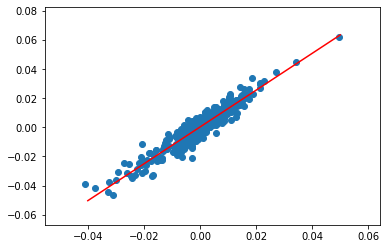

In [51]:
plt.scatter(SPX, NDX)
plt.plot(np.linspace(-0.04, 0.05), np.linspace(-0.04, 0.05)*fit.x[1] + fit.x[0], color = 'r')

<div class="alert alert-block alert-info"> Problem 5.6 </div>
Generate $R$=1,000 samples bootstrap (parametric or non-parametric, you choose) samples of $\alpha,\beta,n$ and $\sigma$:


In [52]:
dist_ML = stats.t(df = np.exp(fit.x[2]) + 1, loc = 0, scale = np.exp(fit.x[3]))

In [53]:
def robust_parametric_bootstrap(loss, Definetheta_guess, dist_ML, R, alpha, beta):
    thetas = np.zeros(4 * R)
    thetas = thetas.reshape(R, 4)
    N = len(SPX)
    for i in range(R):
        BSsample = dist_ML.rvs(size = N)
        fit = opt.minimize(lambda x:loss(x, SPX, alpha + beta * SPX + BSsample), Definetheta_guess,)
        thetas[i] = fit.x
    return thetas
thetahat = robust_parametric_bootstrap(student_regression_loss, guess, dist_ML, 1000, fit.x[0], fit.x[1])

<div class="alert alert-block alert-info"> Problem 5.7 </div>


1. Plot a histogram of the  distributions of  bootstrap samples of $\alpha$,$\beta$, $\sigma$ and $n$.
2. Superimpose the best Gaussian fit to the bootstrap distribution of each parameter.
3. Clearly highlight in the histogram the maximum likelihood estimated of the parameter that you used to generate the distribution.

In [63]:
n_hat[-5:]

array([3.60362513e+01, 4.30514063e+01, 1.07297724e+02, 3.40994595e+02,
       3.79919072e+05])

In [67]:
alpha_hat= np.sort(thetahat[:,0])
beta_hat= np.sort(thetahat[:,1])
n_hat = np.sort(1+ np.exp(thetahat[:,2]))
n_hat = n_hat[:-5] #getting rid of outlier
sigma_hat = np.sort(np.exp(thetahat[:,3]))

<div class="alert alert-block alert-info"> Problem 6.3 </div>

Are  the maximum likelihood estimates obtained in the test period consisted with the expected distribution generated from the training data?

Can you explain why?

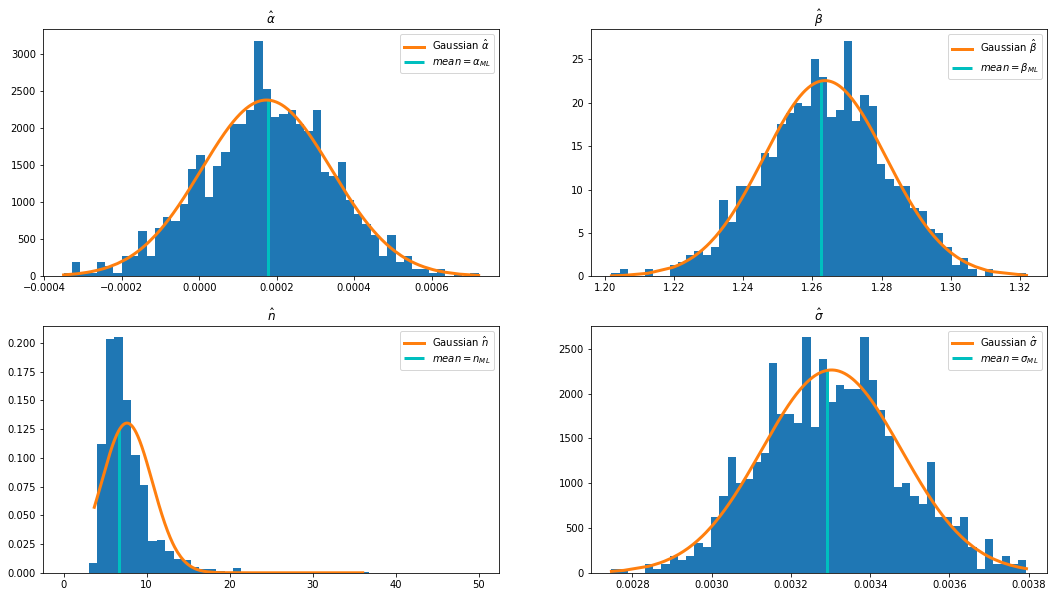

In [69]:
fig = plt.figure(figsize=(18, 10))

plt.subplot(2,2,1)
plt.title(r'$\hat\alpha$')
plt.hist(alpha_hat, bins=50, density = True);
plt.plot(alpha_hat,normal(alpha_hat).pdf(alpha_hat), linewidth=3,label=r"Gaussian $\hat\alpha$")
plt.vlines(fit.x[0], 0,normal(alpha_hat).pdf(fit.x[0]), color = 'c', lw= 3, label =r'$mean = \alpha_{ML}$')
plt.legend()

plt.subplot(2,2,2)
plt.title(r'$\hat\beta$')
plt.hist(beta_hat, bins=50, density = True);
plt.plot(beta_hat,normal(beta_hat).pdf(beta_hat), linewidth=3,label=r"Gaussian $\hat\beta$")
plt.vlines(fit.x[1], 0,normal(beta_hat).pdf(fit.x[1]), color = 'c', lw= 3, label =r'$mean = \beta_{ML}$')
plt.legend()

plt.subplot(2,2,3)
plt.title(r'$\hat n$')
plt.hist(n_hat, density = True, bins = np.linspace(0, 50, 50));
plt.plot(n_hat,normal(n_hat).pdf(n_hat), linewidth=3,label=r"Gaussian $\hat n$")
plt.vlines(1+np.exp(fit.x[2]), 0,normal(n_hat).pdf(1+np.exp(fit.x[2])), color = 'c', lw= 3, label =r'$mean = n_{ML}$')
plt.legend()

plt.subplot(2,2,4)
plt.title(r'$\hat\sigma$')
plt.hist(sigma_hat, bins=50, density = True);
plt.plot(sigma_hat,normal(sigma_hat).pdf(sigma_hat), linewidth=3,label=r"Gaussian $\hat\sigma$")
plt.vlines(np.exp(fit.x[3]), 0,normal(sigma_hat).pdf(np.exp(fit.x[3])), color = 'c', lw= 3, label =r'$mean = \sigma_{ML}$')
plt.legend()

## Bonus Problem 6: Test estimates on new time period

<div class="alert alert-block alert-info"> Problem 6.1 </div>

Compute the maximum likelihood of the regression parameters $\alpha,\beta,n$ and $\sigma$ using the test data we set aside for the years 2020 to the present.

In [70]:
student_regression_loss(fit.x, SPX_test, NDX_test)
fit_new = opt.minimize(lambda x: student_regression_loss(x, SPX_test, NDX_test), fit.x)
fit_new.x

array([ 5.04188490e-04,  1.05536693e+00,  1.31592960e+00, -5.20814955e+00])

<div class="alert alert-block alert-info"> Problem 6.2 </div>

Repeat the graphs of problem 5.7 of the bootstrap distribution of parameters implied from the training data.

Additional over impose on each of the graphs the maximum likelihood parameter estimated during the testing period.

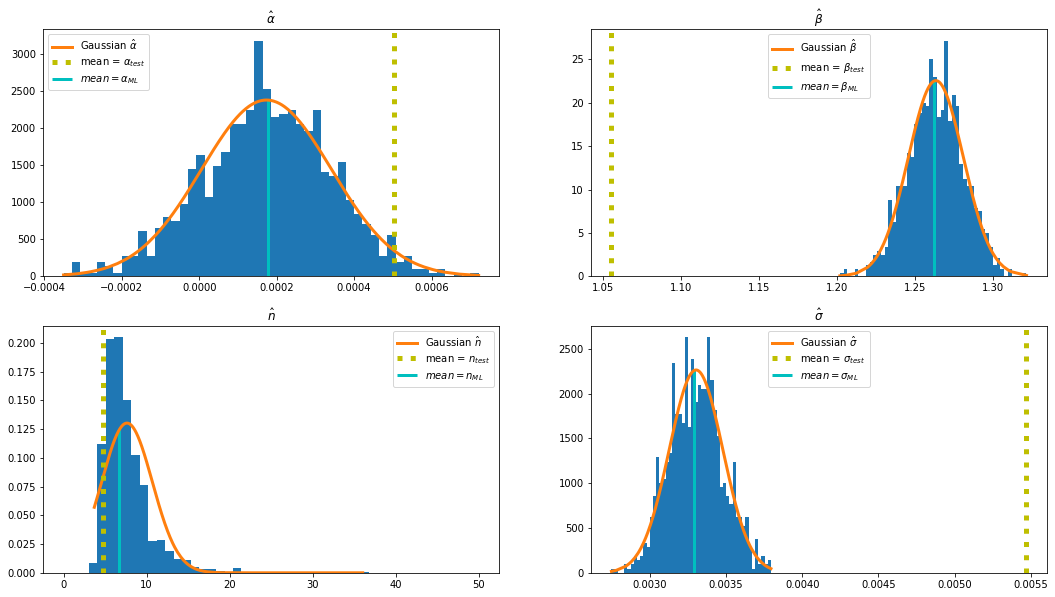

In [71]:
fig = plt.figure(figsize=(18, 10))

plt.subplot(2,2,1)
plt.title(r'$\hat\alpha$')
plt.hist(alpha_hat, bins=50, density = True);
plt.plot(alpha_hat,normal(alpha_hat).pdf(alpha_hat), linewidth=3,label=r"Gaussian $\hat\alpha$")
plt.vlines(fit.x[0], 0,normal(alpha_hat).pdf(fit.x[0]), color = 'c', lw= 3, label =r'$mean = \alpha_{ML}$')
plt.axvline(fit_new.x[0], color = 'y', label = r"mean = $\alpha_{test}$", lw=5, ls= ':')
plt.legend()

plt.subplot(2,2,2)
plt.title(r'$\hat\beta$')
plt.hist(beta_hat, bins=50, density = True);
plt.plot(beta_hat,normal(beta_hat).pdf(beta_hat), linewidth=3,label=r"Gaussian $\hat\beta$")
plt.vlines(fit.x[1], 0,normal(beta_hat).pdf(fit.x[1]), color = 'c', lw= 3, label =r'$mean = \beta_{ML}$')
plt.axvline(fit_new.x[1], color = 'y', label = r"mean = $\beta_{test}$", lw=5, ls= ':')
plt.legend()

plt.subplot(2,2,3)
plt.title(r'$\hat n$')
plt.hist(n_hat, density = True, bins = np.linspace(0, 50, 50));
plt.plot(n_hat,normal(n_hat).pdf(n_hat), linewidth=3,label=r"Gaussian $\hat n$")
plt.vlines(1+np.exp(fit.x[2]), 0,normal(n_hat).pdf(1+np.exp(fit.x[2])), color = 'c', lw= 3, label =r'$mean = n_{ML}$')
plt.axvline(1+ np.exp(fit_new.x[2]), color = 'y', label = r"mean = $n_{test}$", lw=5, ls= ':')
plt.legend()

plt.subplot(2,2,4)
plt.title(r'$\hat\sigma$')
plt.hist(sigma_hat, bins=50, density = True);
plt.plot(sigma_hat,normal(sigma_hat).pdf(sigma_hat), linewidth=3,label=r"Gaussian $\hat\sigma$")
plt.vlines(np.exp(fit.x[3]), 0,normal(sigma_hat).pdf(np.exp(fit.x[3])), color = 'c', lw= 3, label =r'$mean = \sigma_{ML}$')
plt.axvline(np.exp(fit_new.x[3]), color = 'y', label = r"mean = $\sigma_{test}$", lw=5, ls= ':')
plt.legend()

<div class="alert alert-block alert-info"> Problem 6.3 </div>

Are  the maximum likelihood estimates obtained in the test period consisted with the expected distribution generated from the training data?

Can you explain why?